In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


import pickle, time

In previous versions, we explore the selection fo words based on a threshold. While this enabled us to focus on the extreme words that were skewing a specific group, it fails to capture other perhaps more interesting relationships/categories. 


Therefore, in this notebook, we attempt to use a different approach where for each demographic group $g \in \mathcal{G}$, we binarize the range of the values in 10 equal-width intervals and pick 10 words from each interval. 
This will total 100 words per group $g$. Let us denote the set of words for a specific group $W_g$. 

The selection of the words within each bin can be selected in different ways, including:
- Random sample
- Maximize diversity
- Word frequency in pretraining data


Additionally, we've considered selecting words based only on the PMI difference betweeen the gendered pronouns "she" and "he". However, this fails to account other interesting relationships, including PMI difference between the nouns "man" and "woman". One interesting idea can be to use these relationships to help select skewed words. For example, if there are a common set of words that always skews male, then perhaps we could also pick it up.

## Read frequency files

In [45]:
def read_pkl_file(fp: str):
    print("Reading file at", fp)
    start = time.time()
    with open(fp, 'rb') as tff:
        data = pickle.load(tff)
    end = time.time()
    print(f"Time to read file {(end-start)/60:.2f} min")
    return data

def read_original_coccurrence_files() -> dict: # 5GB
    return read_pkl_file("/extra/ucinlp1/cbelem/bias-dataset-project/all_co_words.pkl")

def read_original_tf_files() -> dict: # 16M
    return read_pkl_file("/extra/ucinlp1/cbelem/bias-dataset-project/term_frequency.pkl")

def read_pmi_diff(fp) -> pd.DataFrame: #1.9M
    # Read the PMI difference filepath
    pmi_diff = {"word": [], "pmi_diff": []}
    with open(fp, "rt") as f:
        for row in f:
            word, _, val = row.rpartition(",")
            pmi_diff["word"].append(word)
            pmi_diff["pmi_diff"].append(float(val))
    return pd.DataFrame(pmi_diff).sort_values("pmi_diff").reset_index(drop=True)

In [46]:
# validation 
def filter_term(term: str) -> bool:
    for t in term:
        if not (65 <= ord(t) <= 90 or 97 <= ord(t) <= 122):
            return False
    return True

In [47]:
TERM_COUNTS_DICT = read_original_tf_files()
TERM_COUNTS_DF = pd.DataFrame(TERM_COUNTS_DICT.items(), columns=["word", "counts"])
total_counts_terms = sum(TERM_COUNTS_DICT.values())
TERM_COUNTS_DF["freq"] = TERM_COUNTS_DF["counts"].apply(lambda x: x / total_counts_terms)
TERM_COUNTS_DF['isalpha'] = TERM_COUNTS_DF["word"].apply(filter_term)
TERM_COUNTS_DF["isalpha"].value_counts()

Reading file at /extra/ucinlp1/cbelem/bias-dataset-project/term_frequency.pkl
Time to read file 0.00 min


isalpha
True     512471
False    258403
Name: count, dtype: int64

In [48]:
len(TERM_COUNTS_DF_ALPHA) / 770_874

0.6647921709643859

573059 words are contain letters from the alphabet (and no punctuation and/or numbers). While we may be interested in including numbers in our generated templates, we will leave that for a final ablation study and will now focus on the selection of words that are alphabetical.

In [49]:
# Get the subset of words that are valid ascii
TERM_COUNTS_DF_ALPHA = TERM_COUNTS_DF[TERM_COUNTS_DF["isalpha"]].reset_index(drop=True).sort_values("freq", ascending=False)
TERM_COUNTS_DF_ALPHA

,word,counts,freq,isalpha
0,he,670513865,5.169584e-03,True
1,his,490624599,3.782659e-03,True
2,her,308933466,2.381841e-03,True
3,she,296016282,2.282251e-03,True
4,time,285533364,2.201429e-03,True
...,...,...,...,...
512356,eventopcode,2070,1.595946e-08,True
512357,yumin,2070,1.595946e-08,True
512358,abns,2070,1.595946e-08,True
512359,fontwidth,2070,1.595946e-08,True


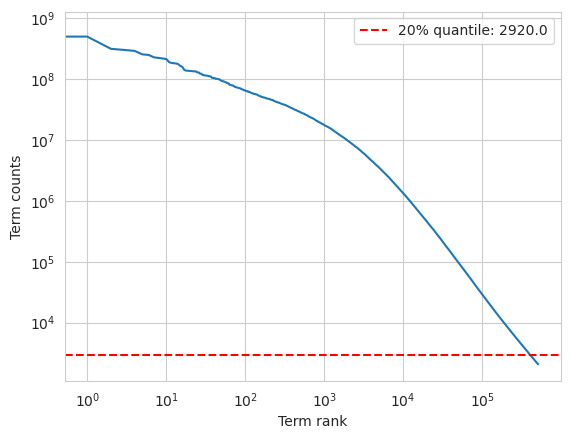

In [50]:
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF_ALPHA)), y=TERM_COUNTS_DF_ALPHA["counts"].values)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.2
q_val = TERM_COUNTS_DF_ALPHA["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [51]:
low_freq_terms_alpha = TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["counts"] < q_val].sort_values("counts", ascending=False)
print("Total number of low freq words:", len(low_freq_terms_alpha))

print("Examples of words with higher rank (lower frequency):")
print("-", "\n- ".join(low_freq_terms_alpha["word"].values[::100]))

Total number of low freq words: 102404
Examples of words with higher rank (lower frequency):
- philipines
- onasanya
- flygplatser
- pruebe
- ameryki
- denge
- biphotons
- prestbury
- bidzina
- menutup
- schneps
- orthogeriatric
- bccc
- appartments
- corboy
- worzel
- helmetless
- lotss
- mlcl
- raffarin
- vaquitas
- singlaub
- emoties
- nackte
- bontempelli
- zigman
- clipp
- startnumber
- ptrint
- luisita
- pathparameter
- qiaochu
- wddoc
- hoppes
- aubaine
- gaid
- kuttans
- leauge
- assignin
- scoopers
- securi
- rapidride
- aceturate
- convosco
- mekanismen
- bddc
- crimsons
- vaudrey
- controlvalue
- sjefen
- separatly
- abgebildet
- emptydatatemplate
- arnoult
- hoatzin
- memmott
- kogaku
- xruns
- kennie
- ferrocytochrome
- zemurray
- intervalli
- jacobaldridge
- breazeal
- tarife
- hasany
- debrunner
- santaella
- axit
- laderman
- diseqc
- bcomp
- touchez
- overdrives
- videntur
- hershberg
- sjors
- strnum
- danieldk
- acidophiles
- vicedo
- nebudu
- stevenx
- hasumi
- nona

In [52]:
# Get the upper quantile (the most common terms)
TERM_COUNTS_DF_ALPHA_UQ = TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["counts"] > q_val]
TERM_COUNTS_DF_ALPHA_UQ

,word,counts,freq,isalpha
0,he,670513865,5.169584e-03,True
1,his,490624599,3.782659e-03,True
2,her,308933466,2.381841e-03,True
3,she,296016282,2.282251e-03,True
4,time,285533364,2.201429e-03,True
...,...,...,...,...
409905,misoperation,2921,2.252057e-08,True
409904,updateweight,2921,2.252057e-08,True
409910,acrasia,2921,2.252057e-08,True
409903,valueargument,2921,2.252057e-08,True


## Max PMI(w, g)

`TERM_COUNTS_DF_ALPHA_UQ` contains the information about the occurring terms.
Let us proceed with our binarization for the previously computed PMI difference, that involved $\text{PMI}(w, \text{"she"}) - \text{PMI}(w, \text{"he"})$, this will be loaded into `ORIG_PMI_DF` variable and we will compute the maximum absolute value for each of the words.


In [53]:
ORIG_PMI_DF = read_pmi_diff("/home/cbelem/projects/pmi_project/experiments-aug-2023/data/pmi-diffs-gender.txt")
ORIG_PMI_DF.head()

,word,pmi_diff
0,homers,-4.745822
1,que,-4.648110
2,pero,-4.541791
3,como,-4.311052
4,cornerback,-4.208671


In [54]:
ORIG_PMI_DF = ORIG_PMI_DF.set_index("word").join(TERM_COUNTS_DF.set_index("word"), how="left")
ORIG_PMI_DF = ORIG_PMI_DF.reset_index()
ORIG_PMI_DF.drop("word", axis=1).corr("kendall")

,pmi_diff,counts,freq,isalpha
pmi_diff,1.000000,-0.115564,-0.115564,0.176319
counts,-0.115564,1.000000,1.000000,-0.065911
freq,-0.115564,1.000000,1.000000,-0.065911
isalpha,0.176319,-0.065911,-0.065911,1.000000


In [55]:
sns.jointplot(ORIG_PMI_DF, y="freq", x="pmi_diff", s=5, alpha=0.5)
plt.yscale("log")

Error in callback <function flush_figures at 0x7fe1f364e820> (for post_execute):



KeyboardInterrupt



### Drop uncommon words

In [56]:
# Mark the most common words
ORIG_PMI_DF["is_common"] = ORIG_PMI_DF["word"].isin(TERM_COUNTS_DF_ALPHA_UQ["word"].values)
ORIG_PMI_DF["is_common"].value_counts()

is_common
True     61785
False     4129
Name: count, dtype: int64

In [57]:
low_freq_terms_orig_pmi = ORIG_PMI_DF[ORIG_PMI_DF["is_common"] == False].sort_values("word")
print("Total number of low freq words:", len(low_freq_terms_orig_pmi))

print("Examples of words dropped due to lower frequency:")
print("-", "\n- ".join(low_freq_terms_orig_pmi["word"].values))

KeyboardInterrupt: 

<AxesSubplot: xlabel='pmi_diff', ylabel='Count'>

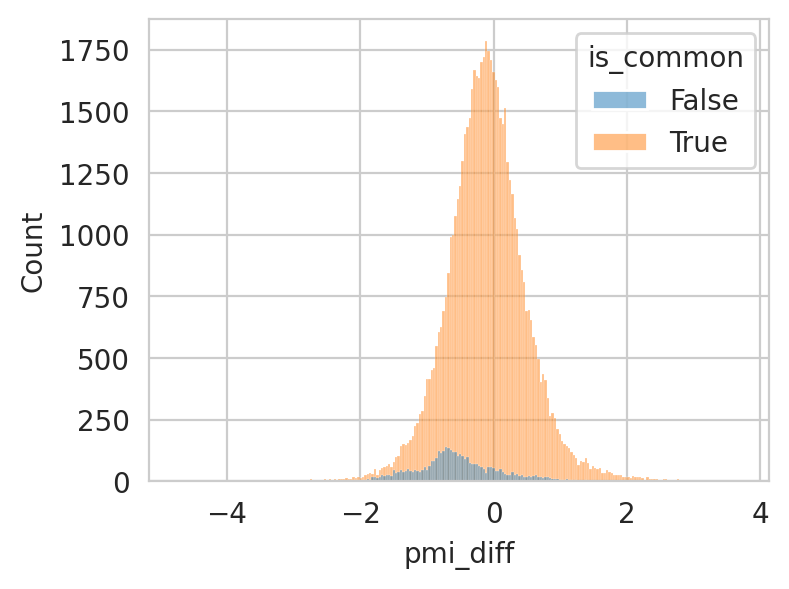

In [58]:
plt.figure(figsize=(4, 3), dpi=200)
sns.histplot(ORIG_PMI_DF, x="pmi_diff", hue="is_common")

In [59]:
ORIG_PMI_DF_UQ = ORIG_PMI_DF[ORIG_PMI_DF["is_common"]].reset_index(drop=True)
print(len(ORIG_PMI_DF), "-->", len(ORIG_PMI_DF_UQ), "; delta =", len(ORIG_PMI_DF)-len(ORIG_PMI_DF_UQ))
ORIG_PMI_DF_UQ.head()

65914 --> 61785 ; delta = 4129


,word,pmi_diff,counts,freq,isalpha,is_common
0,homers,-4.745822,199364,0.000002,True,True
1,que,-4.648110,53628249,0.000413,True,True
2,pero,-4.541791,3228750,0.000025,True,True
3,como,-4.311052,7521373,0.000058,True,True
4,cornerback,-4.208671,300045,0.000002,True,True


In [60]:
ORIG_PMI_DF_UQ.drop("word", axis=1).corr("kendall")

,pmi_diff,counts,freq,isalpha,is_common
pmi_diff,1.000000,-0.099452,-0.099452,NaN,NaN
counts,-0.099452,1.000000,1.000000,NaN,NaN
freq,-0.099452,1.000000,1.000000,NaN,NaN
isalpha,NaN,NaN,NaN,1.0,NaN
is_common,NaN,NaN,NaN,NaN,1.0


### Filtering out Non-English words

We experimented with langdetect library from Google as well, but it performs poorly when identifying individual words, e.g., mentions that "hello" is not English. Leading to a large number of false negatives (claiming english words are not english). 

Fasttext on the other hand proved to be much better at detecting whether individual words are english or not. Besides, it also gives the confidence associated with the prediction.


We will consider a word to be English if it follows at least one of the following rules:
- fasttext model indicates it's an English word with at least 50% confidence
- there exists at least a synset for that word

In [61]:
#!pip install fasttext
# !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [62]:
import fasttext


def are_english_words(words):
    model = fasttext.load_model("lid.176.bin")
    preds = model.predict(words, k=1)
    
    results = []
    for lang, conf in zip(*preds):
        if '__label__en' in lang:
            results.append(("english", conf[0]))
        else:
            results.append((lang, conf[0]))
            
    return results


conf_threshold = 0.5
# Determine whether words are English
LANG = are_english_words(ORIG_PMI_DF_UQ["word"].values.tolist())
LANG = pd.DataFrame.from_records(LANG, columns=["pred_lang", "pred_conf"])

# Create final ORIG_PMI_DF with information about common and english-only words
ORIG_PMI_DF_UQ_LANG = pd.concat((ORIG_PMI_DF_UQ, LANG), axis=1)
ORIG_PMI_DF_UQ_LANG["is_english"] = (ORIG_PMI_DF_UQ_LANG["pred_lang"] == "english") & (ORIG_PMI_DF_UQ_LANG["pred_conf"] >= conf_threshold)
ORIG_PMI_DF_UQ_LANG["is_english"].value_counts()

is_english
True     32807
False    28978
Name: count, dtype: int64

In [72]:
len(ORIG_PMI_DF_UQ_LANG)

49311

### Add information about  WordNET

In [71]:
from nltk.corpus import wordnet

ORIG_PMI_DF_UQ_LANG["wordnet_counts"] = ORIG_PMI_DF_UQ_LANG["word"].apply(lambda x: len(wordnet.synsets(x)))
ORIG_PMI_DF_UQ_LANG["wordnet_counts"].value_counts() / len(ORIG_PMI_DF_UQ_LANG)

wordnet_counts
1     20239
2     12474
0      8643
3      7067
4      4204
5      2673
6      1679
7      1270
8       754
9       575
10      454
11      350
12      248
13      202
15      144
14      136
17       93
16       92
18       74
22       45
19       43
20       40
21       37
23       29
24       23
25       21
27       17
36       14
26       12
38       11
29       10
31        9
30        9
34        9
28        8
32        7
45        7
44        7
42        6
37        6
40        6
33        5
52        5
41        5
39        3
47        2
60        2
75        2
57        2
43        2
61        1
54        1
51        1
50        1
70        1
72        1
46        1
49        1
48        1
35        1
Name: count, dtype: int64

#### Final valid words

In [74]:
def is_english_mask(df: pd.DataFrame):
    return (
        # English words
        (df["is_english"] == True) 
        # non-english words with high confidence and not defined in wordnet
        | ((df["is_english"] == False) & (df["wordnet_counts"] > 0))
    )


mask = is_english_mask(ORIG_PMI_DF_UQ_LANG)

nonengl_terms_orig_pmi = ORIG_PMI_DF_UQ_LANG[~mask].sort_values("word")
print("Total number of non english words:", len(nonengl_terms_orig_pmi))

print("Examples of words dropped due to being classified as not english:")
print("-", "\n- ".join(nonengl_terms_orig_pmi["word"].values[::100]))

Total number of non english words: 5163
Examples of words dropped due to being classified as not english:
- aand
- alicorn
- aquiver
- backflips
- betake
- bor
- carabinieri
- cho
- como
- crunchy
- demi
- doggystyle
- durst
- entendre
- fakin
- flippin
- fuh
- glaive
- guv
- heeler
- hoon
- imager
- interestin
- joey
- kif
- ldots
- logins
- maketh
- mets
- moisturizer
- namespace
- nk
- oi
- oz
- phaser
- ppellant
- pum
- recon
- rien
- sauvignon
- shellshocked
- slimmed
- sponte
- subspecialty
- tanto
- thy
- tres
- unchastity
- vaxxer
- vrai
- wil
- yappy


In [75]:
ORIG_PMI_DF_UQ_LANG[mask].sort_values("word").head()

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts
17791,aa,-0.399441,4206735,3.243344e-05,True,True,english,0.218735,False,3
55156,aaaand,0.584698,20740,1.599030e-07,True,True,english,0.756806,True,0
49557,aaah,0.337405,55354,4.267729e-07,True,True,english,0.876286,True,0
49574,aah,0.337836,351528,2.710240e-06,True,True,[__label__it],0.496236,False,1
60024,aahed,1.113680,3526,2.718505e-08,True,True,english,0.893221,True,1


In [68]:
ORIG_PMI_DF_UQ_ENG = ORIG_PMI_DF_UQ_LANG[mask]
ORIG_PMI_DF_UQ_ENG

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts
0,homers,-4.745822,199364,1.537073e-06,True,True,english,0.845885,True,6
4,cornerback,-4.208671,300045,2.313312e-06,True,True,english,0.338340,False,1
5,defenseman,-4.002896,231801,1.787159e-06,True,True,english,0.662324,True,0
6,fastball,-3.659919,222975,1.719111e-06,True,True,english,0.758250,True,1
7,welterweight,-3.635586,150098,1.157238e-06,True,True,english,0.663944,True,4
...,...,...,...,...,...,...,...,...,...,...
61779,ovulating,3.152254,21174,1.632491e-07,True,True,english,0.722992,True,1
61780,superwoman,3.161764,17589,1.356092e-07,True,True,english,0.613014,True,0
61781,doula,3.232650,42274,3.259276e-07,True,True,[__label__pt],0.266287,False,1
61783,refloated,3.514507,9130,7.039124e-08,True,True,english,0.793005,True,1


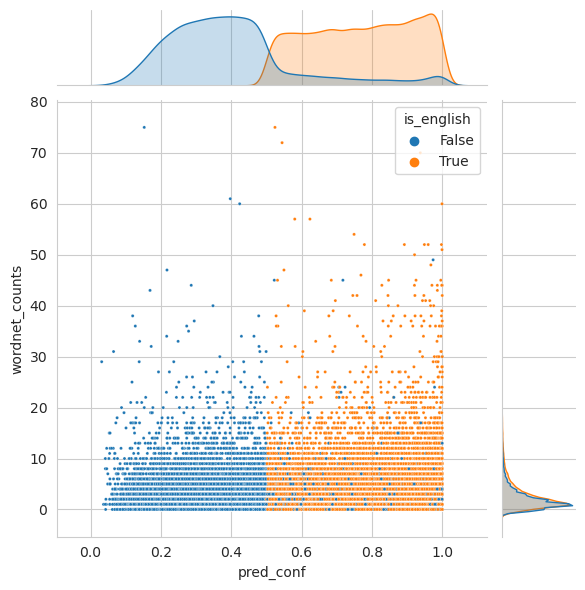

In [69]:
sns.jointplot(ORIG_PMI_DF_UQ_LANG, x="pred_conf", y="wordnet_counts", hue="is_english", s=5)

In [ ]:
sns.jointplot(ORIG_PMI_DF_UQ_LANG, x="pred_conf", y="wordnet_counts", hue="is_english", s=5)

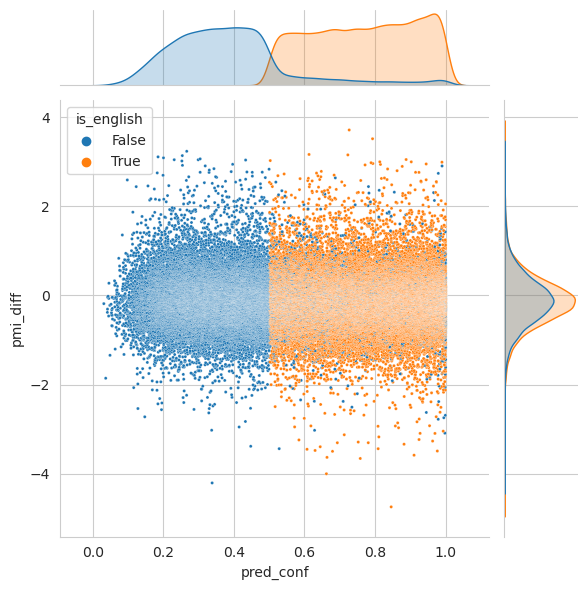

In [79]:
sns.jointplot(ORIG_PMI_DF_UQ_ENG, x="pred_conf", y="pmi_diff", hue="is_english", s=5)

<Figure size 800x600 with 0 Axes>

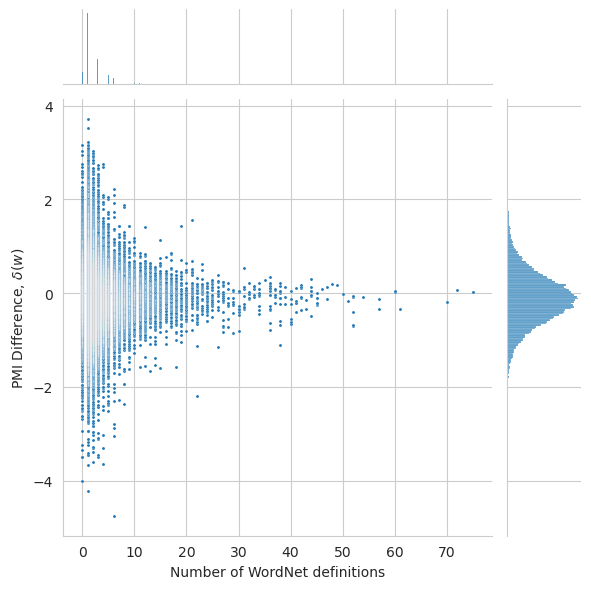

In [90]:
plt.figure(figsize=(4, 3), dpi=200)
sns.jointplot(ORIG_PMI_DF_UQ_ENG, x="wordnet_counts", y="pmi_diff", s=5)
plt.xlabel("Number of WordNet definitions")
plt.ylabel("PMI Difference, $\delta(w)$")
plt.show()

In [81]:
TERM_COUNTS_DF.shape

(770874, 4)

In [86]:
ORIG_PMI_DF_UQ_ENG.shape[0], TERM_COUNTS_DF.shape[0], round(ORIG_PMI_DF_UQ_ENG.shape[0] / TERM_COUNTS_DF.shape[0], 4)

(56622, 770874, 0.0735)

### Obtain the words

In the variable ORIG_PMI_DF_UQ_ENG, we have the selected English words.
We have yet to reduce the set of words to the ones having the same root.
Since we're using stratified sampling to select one word from each bin, we do not need to care too much about this. If two words with the same root are selected, it is likely that it is because they were sampled from different bins. In which case, it may suggest that there is a significant difference.

In [91]:
num_bins = 20
# define PMI range
pmi_diff_max = ORIG_PMI_DF_UQ_ENG["pmi_diff"].apply(np.abs).describe()["max"]
print(pmi_diff_max)

pmi_diff_max = np.ceil(pmi_diff_max)
bins = np.linspace(-pmi_diff_max, pmi_diff_max, num_bins)

ORIG_PMI_DF_UQ_ENG.loc[:,"pmi_diff_bins"] = pd.cut(ORIG_PMI_DF_UQ_ENG["pmi_diff"], bins)
ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"].value_counts()

4.74582214318505


/tmp/ipykernel_2119915/1280635392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ORIG_PMI_DF_UQ_ENG.loc[:,"pmi_diff_bins"] = pd.cut(ORIG_PMI_DF_UQ_ENG["pmi_diff"], bins)


pmi_diff_bins
(-0.263, 0.263]     21748
(-0.789, -0.263]    16106
(0.263, 0.789]       9583
(-1.316, -0.789]     4645
(0.789, 1.316]       2262
(-1.842, -1.316]      980
(1.316, 1.842]        665
(1.842, 2.368]        239
(-2.368, -1.842]      188
(2.368, 2.895]         87
(-2.895, -2.368]       56
(2.895, 3.421]         25
(-3.421, -2.895]       24
(-3.947, -3.421]        9
(3.421, 3.947]          2
(-4.474, -3.947]        2
(-5.0, -4.474]          1
(3.947, 4.474]          0
(4.474, 5.0]            0
Name: count, dtype: int64

In [92]:
intervals = sorted(ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"].unique())
interval_idx_middle = [ix for ix, interval in enumerate(intervals) if 0 in interval][0]
intervals[interval_idx_middle]

Interval(-0.263, 0.263, closed='right')

In [102]:
sampling_bin = ORIG_PMI_DF_UQ_ENG[ORIG_PMI_DF_UQ_ENG["pmi_diff_bins"] == intervals[interval_idx_middle]]
sampling_bin = sampling_bin.sort_values("freq", ascending=False)
sampling_bin.head(30)

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts,pmi_diff_bins
35518,time,-0.018094,285533364,0.002201,True,True,english,0.641759,True,15,"(-0.263, 0.263]"
30977,new,-0.110778,250799315,0.001934,True,True,english,0.633912,True,12,"(-0.263, 0.263]"
42495,like,0.138807,245503110,0.001893,True,True,english,0.987523,True,11,"(-0.263, 0.263]"
30411,type,-0.121941,224253042,0.001729,True,True,english,0.319179,False,8,"(-0.263, 0.263]"
37961,said,0.035295,219624681,0.001693,True,True,english,0.999924,True,12,"(-0.263, 0.263]"
46679,let,0.247119,214854845,0.001657,True,True,english,0.774091,True,8,"(-0.263, 0.263]"
34491,right,-0.040277,210372007,0.001622,True,True,english,0.127132,False,36,"(-0.263, 0.263]"
39624,him,0.070621,180492358,0.001392,True,True,english,1.000020,True,0,"(-0.263, 0.263]"
25643,use,-0.221774,178440341,0.001376,True,True,[__label__kn],0.271104,False,13,"(-0.263, 0.263]"
27459,people,-0.183108,162993693,0.001257,True,True,english,0.990155,True,6,"(-0.263, 0.263]"


In [103]:
sampling_bin.tail(30)

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts,pmi_diff_bins
45468,rhapsodize,0.212775,3035,2.339950e-08,True,True,[__label__it],0.653362,False,2,"(-0.263, 0.263]"
45572,pernickety,0.215731,3030,2.336095e-08,True,True,[__label__pl],0.188206,False,1,"(-0.263, 0.263]"
43872,combadge,0.172111,3030,2.336095e-08,True,True,english,0.664239,True,0,"(-0.263, 0.263]"
27255,frankest,-0.187608,3023,2.330698e-08,True,True,[__label__de],0.260547,False,2,"(-0.263, 0.263]"
29176,euphorically,-0.148025,3017,2.326072e-08,True,True,english,0.670471,True,0,"(-0.263, 0.263]"
37566,disarrange,0.026291,3012,2.322217e-08,True,True,english,0.283108,False,2,"(-0.263, 0.263]"
38983,obdurately,0.056925,3008,2.319133e-08,True,True,english,0.882838,True,1,"(-0.263, 0.263]"
42806,fornicated,0.146741,3005,2.316820e-08,True,True,english,0.895264,True,1,"(-0.263, 0.263]"
31892,flubbing,-0.092761,3004,2.316049e-08,True,True,english,0.715825,True,1,"(-0.263, 0.263]"
45560,hypnotising,0.215455,2995,2.309110e-08,True,True,[__label__vi],0.235421,False,1,"(-0.263, 0.263]"


In [107]:
sampling_bin.sort_values("pmi_diff").head(30)

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts,pmi_diff_bins
23777,interlopers,-0.263110,47924,3.694885e-07,True,True,[__label__nl],0.226761,False,1,"(-0.263, 0.263]"
23778,het,-0.263107,6239640,4.810690e-05,True,True,[__label__nl],1.000060,False,1,"(-0.263, 0.263]"
23779,noggin,-0.263105,67489,5.203324e-07,True,True,[__label__af],0.242812,False,1,"(-0.263, 0.263]"
23780,amateurish,-0.263085,53987,4.162335e-07,True,True,[__label__fr],0.524947,False,1,"(-0.263, 0.263]"
23781,realistic,-0.263050,2936849,2.264277e-05,True,True,english,0.665515,True,3,"(-0.263, 0.263]"
23782,decision,-0.263035,29946416,2.308834e-04,True,True,english,0.925985,True,5,"(-0.263, 0.263]"
23783,dissect,-0.262934,235953,1.819170e-06,True,True,english,0.346610,False,2,"(-0.263, 0.263]"
23784,weasels,-0.262934,38762,2.988505e-07,True,True,english,0.856461,True,2,"(-0.263, 0.263]"
23785,becase,-0.262899,7031,5.420819e-08,True,True,english,0.991358,True,0,"(-0.263, 0.263]"
23786,concrete,-0.262834,4695160,3.619914e-05,True,True,english,0.732422,True,5,"(-0.263, 0.263]"


In [108]:
sampling_bin.sort_values("pmi_diff").tail(30)

,word,pmi_diff,counts,freq,isalpha,is_common,pred_lang,pred_conf,is_english,wordnet_counts,pmi_diff_bins
47206,cosset,0.262353,3863,2.978328e-08,True,True,[__label__ie],0.116073,False,1,"(-0.263, 0.263]"
47205,copywriters,0.262353,18088,1.394564e-07,True,True,english,0.949212,True,1,"(-0.263, 0.263]"
47207,reprised,0.262359,58720,4.527244e-07,True,True,english,0.756466,True,1,"(-0.263, 0.263]"
47208,trolls,0.262436,394083,3.038334e-06,True,True,[__label__it],0.316244,False,11,"(-0.263, 0.263]"
47209,quickens,0.262452,23485,1.810666e-07,True,True,english,0.408384,False,5,"(-0.263, 0.263]"
47210,affaire,0.262517,160119,1.234499e-06,True,True,[__label__fr],0.919619,False,1,"(-0.263, 0.263]"
47211,touchable,0.262517,21204,1.634804e-07,True,True,[__label__es],0.594922,False,1,"(-0.263, 0.263]"
47212,befriend,0.262525,93636,7.219227e-07,True,True,[__label__de],0.302224,False,1,"(-0.263, 0.263]"
47213,dormitory,0.262569,201256,1.551660e-06,True,True,english,0.355169,False,2,"(-0.263, 0.263]"
47214,zipped,0.262584,165678,1.277358e-06,True,True,english,0.984190,True,2,"(-0.263, 0.263]"


In [ ]:
ORIG_PMI_DF_UQ_ENG["skews"] = ["male"] * len(ORIG_PMI_DF_UQ_ENG)
female_mask = ORIG_PMI_DF_UQ_ENG["pmi_diff"] > 0
ORIG_PMI_DF_UQ_ENG.loc[female_mask, "skews"] = "female"

neutral_mask = (ORIG_PMI_DF_UQ_ENG["pmi_diff"] >= -0.263) & (ORIG_PMI_DF_UQ_ENG["pmi_diff"] <= 0.263)
ORIG_PMI_DF_UQ_ENG.loc[neutral_mask, "skews"] = "neutral"

ORIG_PMI_DF_UQ_ENG["skews"].value_counts() / len(ORIG_PMI_DF_UQ_ENG)

In [ ]:
ORIG_PMI_DF_UQ_ENG.sample()

In [ ]:
def get_wordnet_info(df: pd.DataFrame):
    results = []
    for ix, row in df.iterrows():
        wordnet_defs = {}
        
        if row["wordnet_counts"] > 0:
            synsets = wordnet.synsets(row["word"])
            wordnet_defs = {s.name(): s.definition() for s in synsets}
            
        results.append(wordnet_defs)
        
    return results


wordnet_sample = get_wordnet_info(ORIG_PMI_DF_UQ_ENG)
ORIG_PMI_DF_UQ_ENG["wordnet_definitions"] = wordnet_sample

In [ ]:
ORIG_PMI_DF_UQ_ENG.to_csv("../results__pool_of_words_by_pmi.csv", index=None)

In [ ]:
ORIG_PMI_DF_UQ_ENG_NEUTRAL = ORIG_PMI_DF_UQ_ENG[ORIG_PMI_DF_UQ_ENG["skews"] == "neutral"].copy()
ORIG_PMI_DF_UQ_ENG_NEUTRAL.to_csv("../results__neutral__pool_of_words_by_pmi.csv", index=None)
len(ORIG_PMI_DF_UQ_ENG_NEUTRAL)

In [ ]:
import os
BASE_DIR = ""
SAMPLES = []
for i, seed in enumerate((9123, 19223, 8172361, 91283, 72613)):
    sample = ORIG_PMI_DF_UQ_ENG_NEUTRAL.sample(n=100, replace=False, random_state=seed)
    
    for num in (5, 10, 20):
        os.makedirs(f"../results-words{num}/words{i+1}", exist_ok=True)
        sample.to_csv(f"../results-words{num}/words{i+1}/selected_words__{seed}.csv")
        words = sorted(sample["word"].unique())

        with open(f"../results-words{num}/words{i+1}/words.txt", "w") as f:
            f.write("\n".join(words))

In [ ]:
sample = ORIG_PMI_DF_UQ_ENG.groupby('pmi_diff_bins', group_keys=False).apply(lambda x: x.sample(frac=0.005))
sample["skews"].value_counts() / len(sample)

In [ ]:
sample["pmi_diff_bins"].value_counts() / len(sample)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(ORIG_PMI_DF_UQ_ENG, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Original: {len(ORIG_PMI_DF_UQ_ENG)}", stat="probability")
sns.histplot(sample, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Sample: {len(sample)}", stat="probability")
plt.legend()

In [ ]:
sample2 = ORIG_PMI_DF_UQ_ENG.groupby('pmi_diff_bins', group_keys=False).apply(lambda x: x.sample(min(len(x), 10), replace=False))
sample2["skews"].value_counts() / len(sample2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(ORIG_PMI_DF_UQ_ENG, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Original: {len(ORIG_PMI_DF_UQ_ENG)}", stat="probability")
sns.histplot(sample2, x="pmi_diff", binwidth=0.1, ax=ax, label=f"Sample: {len(sample2)}", stat="probability")
plt.legend()
sample2["pmi_diff_bins"].value_counts() / len(sample2)

#### add wordnet info

In [ ]:
sorted(sample2.word)

### Persist

In [ ]:
sample.to_csv("../results/selected_words.csv", index=None)

In [ ]:
TERM_COUNTS_DICT["he"],TERM_COUNTS_DICT["his"], TERM_COUNTS_DICT["him"]

In [ ]:
TERM_COUNTS_DICT["she"], TERM_COUNTS_DICT["her"]

In this file, we plan to select a set of words from the pretraining set in an automatic fashion. We'll try to make an intuitive choice by considering the following:
 
 $$\text{PMI}(w, \text{"she"}) - \text{PMI}(w, \text{"he"}) = log \frac{P(\text{"she"}|w)}{P(\text{"he"}|w)}$$

Thus, we will deem words whose odd ratio is 2.5 times smaller or larger to be unproprortionally skewed. We will not consider these words for our bias benchmark creation:
- Remove words whose $\frac{P(\text{"she"}|w)}{P(\text{"he"}|w)} \geq \tau \vee \frac{P(\text{"he"}|w)}{P(\text{"she"}|w)} \geq \tau$, where $\tau = 2.5$


## Check original words frequency


In [ ]:
orig_df = pd.read_csv("../../experiments-tacl-june-2023/data/pmi_diffs_selected.csv")
# orig_df = orig_df[~orig_df["selected"].isna()]

orig_words_set = set(orig_df["word"].unique())
orig_df["is_common"] = orig_df["word"].isin(TERM_COUNTS_DF_ALPHA_UQ["word"].values)
orig_df["is_common"].value_counts()

In [ ]:
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF_ALPHA)), y=TERM_COUNTS_DF_ALPHA["counts"].values)

idx = np.array(TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["word"].isin(orig_df["word"])].index)
sns.scatterplot(x=idx, y=TERM_COUNTS_DF_ALPHA["counts"].values[idx], color="red", s=15)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.2
q_val = TERM_COUNTS_DF_ALPHA["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [ ]:
current_df = pd.read_csv("../../experiments-aug-2023/results/selected_words.csv")
current_df

In [ ]:
sns.lineplot(x=np.arange(len(TERM_COUNTS_DF_ALPHA)), y=TERM_COUNTS_DF_ALPHA["counts"].values)

idx = np.array(TERM_COUNTS_DF_ALPHA[TERM_COUNTS_DF_ALPHA["word"].isin(current_df["word"])].index)
sns.scatterplot(x=idx, y=TERM_COUNTS_DF_ALPHA["counts"].values[idx], color="black", s=15)
plt.xscale("log"); plt.xlabel("Term rank")
plt.yscale("log"); plt.ylabel("Term counts")

q = 0.2
q_val = TERM_COUNTS_DF_ALPHA["counts"].quantile(q)
plt.axhline(q_val, label=f"{q:.0%} quantile: {q_val}", ls="--", c="r")
plt.legend()
plt.show()

In [ ]:
ORIG_PMI_DF_UQ_ENG.sort_values("counts", ascending=False).head(30)